<a href="https://colab.research.google.com/github/baixianger/DLAV-2022/blob/main/homeworks/hw2/Linear%20Classification%20pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Linear Classification

 Implement Linear Classification using pytorch. This consists of having fully connected layers connected one after the other and ReLu activation functions between them.
 
 Build a neural network with a minimun of 2 layers in order to do classification.

Permit the notebook to access your drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data as utils
import time
import pdb
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)    # reproducible

Get the dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


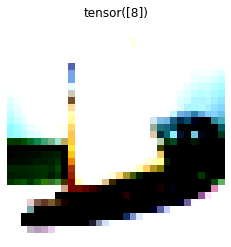

In [3]:
def get_train_valid_loader(data_dir='../data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.02,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=1, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

def plot_images(X, labels):
    plt.figure()
    plt.imshow(X.squeeze())
    plt.axis('off')
    plt.title(f'{labels}')

trainloader, valloader = get_train_valid_loader(show_sample=True, num_workers=8)

Define the network

In [7]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        self.fc1 = torch.nn.Linear(n_feature, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, n_output)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################


    def forward(self, x):
        x = x.view(x.size(0),-1)
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        ################################################################################
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        return x

In [8]:
################################################################################
# TODO:                                                                        #
# Define the parameters of the network the way you want it to be.              #
# Choose an Optimizer that will be used to minimize the loss function.         #
################################################################################
net = Net(n_feature=3*32*32, n_hidden=1024, n_output=10)     # define the network
print(net)  # net architecture

# Loss and Optimizer (Try different learning rates)
# Softmax is internally computed.
# Set parameters to be updated. 

optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)  # Choose the optimizer you want and tune its hyperparameter
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Net(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)


In [9]:
#traindataset = utils.TensorDataset(X_train, y_train)
#trainloader = utils.DataLoader(traindataset, batch_size=64, shuffle=True)

epochs = 50
steps = 0
print_every = 100
for e in range(epochs):
    start = time.time()
    print(f'Epoch{e:2d}/{epochs}')
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        ################################################################################
        images.resize_(images.size()[0], 3*32*32)
        optimizer.zero_grad()
        output = net(images)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
        if steps % print_every == 0:
                stop = time.time()
                # Test accuracy
                net.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in valloader:
                          images, labels = data
                          outputs = net(images)
                          _, predicted = torch.max(F.softmax(outputs).data, 1)
                          total += labels.size(0)
                          correct += (predicted == labels).sum().item()

                    print('\tAccuracy of the network on the %d val images: \
                    %d %%' % (total,100 * correct / total))

                start = time.time()

Epoch 0/50


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


	Accuracy of the network on the 1000 val images:                     32 %


KeyboardInterrupt: ignored

After training, the model should be saved to be tested on the test dataset or to be used in a real-life application. To save your model in pytorch:

In [ ]:
torch.save(net.state_dict(), 'drive/MyDrive/Colab Notebooks/linearClassifier_pytorch.ckpt')

Remeber the above path. You need to load your trained model in another notebook:

In [ ]:
checkpoint = torch.load("drive/MyDrive/Colab Notebooks/linearClassifier_pytorch.ckpt")
net.load_state_dict(checkpoint)

<All keys matched successfully>